## Manual Download of Landsat Imagery from Earth Explorer

### Earth Explorer Manual Download

 
 - Visit https://earthexplorer.usgs.gov/, click login, and complete the registration process to create an account. Registration is free but email confirmation required is required, feel free to use your Temple University email account.
 - Login to earth explorer with your account
 - Search for the following scene: `LC08_L2SP_016040_20210317_20210328_02_T1`
   - LC08 refers to Landsat 8, which is the satellite that captured the imagery.
   - L2SP refers to the Level 2 Surface Reflectance product, which means the image has been atmospherically corrected to produce surface reflectance values, a common product for Landsat 8.
   - 016040 is the Path/Row of the Landsat scene. Landsat data is organized into a grid of paths and rows, where 016 is the Path (the longitudinal strip of the scene) and 040 is the Row (the latitudinal strip). Together, this identifies the specific scene within the Landsat grid system.
   - 20210317 represents the acquisition date of the image in YYYYMMDD format, so in this case, the image was captured on March 17, 2021.
   - 20210328: represents the processing date in YYYYMMDD format, which is when the image was processed and made available. In this case, it was processed on March 28, 2021.
   - 02 is the scene number (or version) associated with this particular Landsat image. The scene number is part of the file naming convention used by the USGS to identify different versions of the same scene.
   - T1 indicates the processing level of the data. T1 generally refers to Terrain Corrected data, meaning that geometric corrections have been applied to the image to align it properly to the Earth’s surface.
 - Under Landsat, select the corresponding year, then open the additional criteria tab and input the fields listed above.
  - When you have identified the scene, select Download Options. 
  - Select Level-2 Surface Reflectance Bands, you will a list of bands included in the scene.
  - Download the following bands
    - SR_B2.TIF: Band 2 (Blue)
    - SR_B3.TIF: Band 3 (Green)
    - SR_B4.TIF: Band 4 (Red)
    - SR_B5.TIF: Band 5 (Near-Infrared)
  - Place the files in the `outputs/` folder. 

### Combine Raster Bands

In [1]:
import rasterio
import numpy as np
from rasterio.enums import Resampling

In [2]:
# Define the paths to the individual band files
band_paths = [
    "output/LC08_L2SP_016040_20210317_20210328_02_T1_SR_B2.TIF",
    "output/LC08_L2SP_016040_20210317_20210328_02_T1_SR_B3.TIF",
    "output/LC08_L2SP_016040_20210317_20210328_02_T1_SR_B4.TIF",
    "output/LC08_L2SP_016040_20210317_20210328_02_T1_SR_B5.TIF"
]

# Read in the bands
bands = []
for band_path in band_paths:
    with rasterio.open(band_path) as src:
        band = src.read(1)  # Read the first band (this will be a 2D array)
        bands.append(band)

# Stack the bands into a 3D array (bands x rows x columns)
stacked_bands = np.array(bands)



In [3]:
# Get the metadata from one of the bands to preserve it
with rasterio.open(band_paths[0]) as src:
    meta = src.meta

# Update the metadata to reflect the number of bands
meta.update(count=len(band_paths))

print(meta)



{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7651, 'height': 7801, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]'), 'transform': Affine(30.0, 0.0, 364485.0,
       0.0, -30.0, 3310215.0)}


In [4]:
# Write the stacked bands to a new multi-band GeoTIFF
output_path = 'output/multi_band_output.tif'
with rasterio.open(output_path, 'w', **meta) as dst:
    for i in range(len(band_paths)):
        dst.write(stacked_bands[i], i + 1)  # Write each band to the corresponding index (1-indexed)

print(f"Multi-band TIFF saved as {output_path}")

Multi-band TIFF saved as output/multi_band_output.tif


### Calculate NDVI

In [5]:
import matplotlib.pyplot as plt

In [6]:
input_tif = 'output/multi_band_output.tif'

with rasterio.open(
    input_tif, mode="r", nodata=0) as src:
    # read in the array, band 3 first, then band 2, then band 1
    arr = src.read([3, 2, 1])
    # the array has three bands
    print("Array shape:", arr.shape)
    # save profile for writing crs to new files
    profile = src.profile
    red = src.read(1)  # Red band (usually the first band)
    nir = src.read(4)  # NIR band (e.g., 4th band, depending on your dataset)

# Save first raster
with rasterio.open(
        "output/naic_band_red.tif",
        mode="w",
        driver="GTiff",
        height=red.shape[0],
        width=red.shape[1],
        count=1,
        dtype=red.dtype,
        crs=profile["crs"],
        transform=profile["transform"],
) as new_dataset:
        new_dataset.write(red, 1)

# Save second raster
with rasterio.open(
        "output/naic_band_nir.tif",
        mode="w",
        driver="GTiff",
        height=nir.shape[0],
        width=nir.shape[1],
        count=1,
        dtype=nir.dtype,
        crs=profile["crs"],
        transform=profile["transform"],
) as new_dataset:
        new_dataset.write(nir, 1)

Array shape: (3, 7801, 7651)


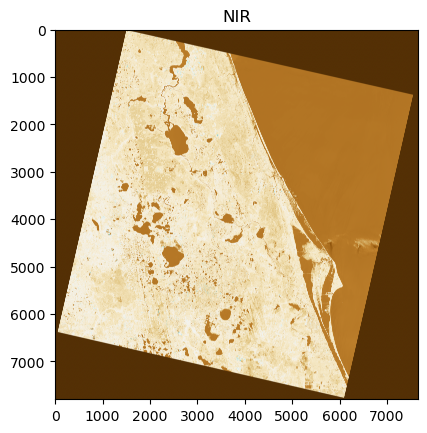

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(None, (7801, 7651))

In [7]:
# Open raster and plot
band_nir = rasterio.open("output/naic_band_nir.tif").read(1)
plt.imshow(band_nir, cmap = "BrBG")
plt.title("NIR")
plt.show()

# View raster values
print(band_nir), band_nir.shape

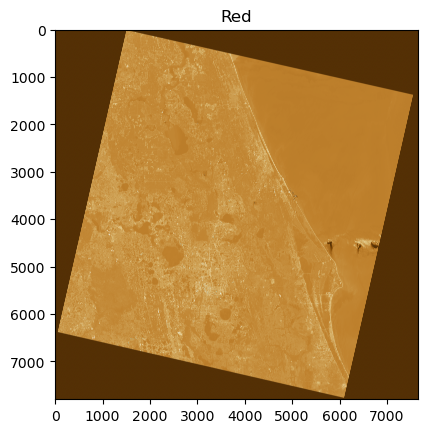

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(None, (7801, 7651))

In [8]:
band_red = rasterio.open("output/naic_band_red.tif").read(1)
plt.imshow(band_red, cmap = "BrBG")
plt.title("Red")
plt.show()

# View raster values
print(band_red), band_red.shape

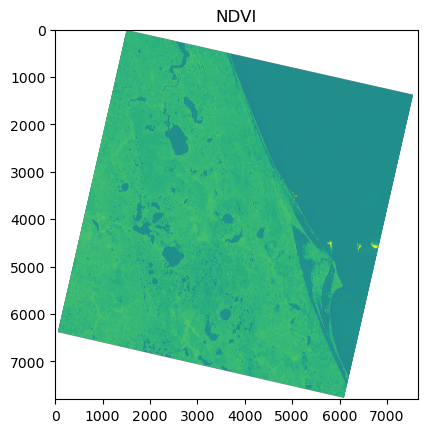

Raster values:
 [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [9]:

# Open raster (Landsat 8, Collection 2 Level-2)
# Band 1 - Blue, Band 2 - Green, Band 3 - Red, Band 4 - Near Infrared
# Source: https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-8-9-olitirs-collection-2-level-2

# Allow division by zero
np.seterr(divide = "ignore", invalid = "ignore")

# Calculate NDVI
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

# Set pixels whose values are outside the NDVI range (-1, 1) to NaN
# Likely due to errors in the Landsat imagery
ndvi[ndvi > 1] = np.nan
ndvi[ndvi < -1] = np.nan

# Plot raster
plt.imshow(ndvi)
plt.title("NDVI")
plt.show()

# Show raster values
print("Raster values:\n", ndvi)

## US Census Tiger Boundaries

### FIPS code Structure

![Alt text](https://www.census.gov/content/dam/Census/newsroom/blogs/2014/07/understanding-geographic-relationships-counties-places-tracts-and-more/geo1.jpg)

![Alt text](images/fips.png)

#### Download from US Census Tiger Lines FTP Server

In [4]:
import os
import requests
import zipfile
import glob
import geopandas as gpd

# Step 1: Define the URL for the zipped shapefile
url = "https://www2.census.gov/geo/tiger/TIGER2024/TRACT/tl_2024_42_tract.zip"  # Example URL
unzip_destination = "output"

# Step 2: Download the zip file
response = requests.get(url)
zip_file_path = "county_shapefile.zip"

# Save the content of the zip file to disk
with open(zip_file_path, 'wb') as file:
    file.write(response.content)

print(f"Downloaded {zip_file_path}")

# Unzip the downloaded file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_destination)  # Specify the directory where to unzip the files
    print(f"Extracted files to {unzip_destination}/")

Downloaded county_shapefile.zip
Extracted files to output/


#### Load in Geodataframe

In [5]:
# Use glob to find all .shp files in the folder (and subdirectories if needed)
shp_files = glob.glob(f"{unzip_destination}/*.shp")

# If a shapefile was found, load the first one into GeoPandas
if shp_files:
    shp_file_path = shp_files[0]  # Choose the first found shapefile (or iterate over all if needed)
    print(f"Found shapefile: {shp_file_path}")
    gdf = gpd.read_file(shp_file_path)
    print("GeoDataFrame loaded successfully!")
    print(gdf.head())  # Display the first few rows
else:
    print("No shapefile (.shp) found in the specified directory.")

Found shapefile: output/tl_2024_42_tract.shp
GeoDataFrame loaded successfully!
  STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ     NAME  \
0      42      017  100102  42017100102  1400000US42017100102  1001.02   
1      42      017  100103  42017100103  1400000US42017100103  1001.03   
2      42      013  010701  42013010701  1400000US42013010701   107.01   
3      42      013  011202  42013011202  1400000US42013011202   112.02   
4      42      013  011201  42013011201  1400000US42013011201   112.01   

               NAMELSAD  MTFCC FUNCSTAT     ALAND   AWATER     INTPTLAT  \
0  Census Tract 1001.02  G5020        S   7695740  2422611  +40.0745577   
1  Census Tract 1001.03  G5020        S   1578123    14537  +40.0682737   
2   Census Tract 107.01  G5020        S  13212402     5907  +40.5473420   
3   Census Tract 112.02  G5020        S   2957912        0  +40.4259841   
4   Census Tract 112.01  G5020        S   3087322        0  +40.4360357   

       INTPTLON          

#### Filter to Census Tracts in Philadelphia

<Axes: >

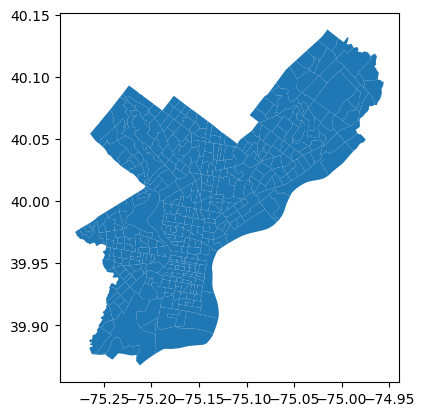

In [6]:
filtered_gdf = gdf[gdf["COUNTYFP"] == "101"]

filtered_gdf.plot()